# This notebook removes the tokenization for repetition

In [ ]:
from pathlib import Path
import pandas as pd
import re

In [ ]:
#Get the list of all of the step files
step_files = list(Path("C:/Users/brent/Desktop/StepMania 5").rglob("*.[dD][wW][iI]"))

#Get the list of all of the step files
song_files = list(Path("C:/Users/brent/Desktop/StepMania 5").rglob("*.[mM][pP][3]"))

In [ ]:
print(len(song_files), len(step_files))

In [ ]:
def process_song(path, title):
    #Open File
    text_file = open(path, "r")
    lines = text_file.readlines()
    text_file.close()
    
    #Combine all text into single line
    song = "".join(lines)
    
    #Remove newline characters
    song = re.sub('\n', '', song)
    
    #Split on semicolon and then add the semicolons back into the respective lines
    song = song.split(';')
    song = [line+';' for line in song][:-1]
    
    #Remove lines that start with 2 // (some files had this for some reason)
    song = [line for line in song if (line.find('//') == -1)]
    
    #Create a dataframe of the song
    df = pd.DataFrame()
    df[title] = song
    return df

def pull_all_step_patterns(song, row):
    song = song[row].str.split(":", n = 3, expand = True)
    song = song[song[0].isin(["#SINGLE","#SOLO"])]
    
    return song

def join_all_step_patterns(step_files):
    songs = pd.DataFrame()
    for row, path in enumerate(step_files):
        df = process_song(path, row)
        df = pull_all_step_patterns(df, row)
        #songs = pd.merge(songs, df, left_index=True, right_index=True, how="outer")
        songs = pd.concat([songs,df])
    
    return songs

In [ ]:
songs = join_all_step_patterns(step_files)

In [ ]:
songs = songs.reset_index()
songs = songs[[1,3]]
songs.columns = ['label','text']

#Split the song into characters with spaces
songs['text'] = songs['text'].apply(lambda x: " ".join(x))

#Remove the trailing semicolon as we can add it back in when we are done predicting songs
songs['text'] = songs['text'].apply(lambda x: x[:-1])

In [ ]:
songs.head()

In [ ]:
songs.to_csv("songs.csv", index=False)

# Train our Language Model

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

In [ ]:
from pathlib import Path
import pandas as pd
import re
import string

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

cwd = os.getcwd()
path = Path(cwd)

In [ ]:
all_letters = list(string.printable + string.whitespace)

#We don't want to remove repetition in the DDR song as that is part of it
customtokenizer = Tokenizer(pre_rules= [], post_rules=[])

processors = [TokenizeProcessor(tokenizer=customtokenizer, mark_fields=False),
            NumericalizeProcessor(vocab=Vocab.create(all_letters, max_vocab=1000, min_freq=0))]

data = (TextList.from_csv(path, 'songs.csv', cols='text', processor=processors)
                .split_by_rand_pct(0.2)
                .label_for_lm()
                .databunch(bs=192))
data.save('data_block_lm2.pkl')

In [ ]:
data_lm = load_data(path, 'data_block_lm2.pkl',bs=192)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7))

In [ ]:
learn.save('fit_head_no_tok')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned_no_tok')
learn.save_encoder('fine_tuned_enc_no_tok')

In [ ]:
TEXT = ""
N_WORDS = 200
N_SENTENCES = 1
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

# Now we work on the classifier

In [2]:
from pathlib import Path
import pandas as pd
import re
import string

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

cwd = os.getcwd()
path = Path(cwd)

In [3]:
#Try out the datablock API to see if we can replicate and use either no tokenization or our custom tokenizer
all_letters = list(string.printable + string.whitespace)

#We don't want to remove repetition in the DDR song as that is part of it
customtokenizer = Tokenizer(pre_rules= [], post_rules=[])

processors = [TokenizeProcessor(tokenizer=customtokenizer, mark_fields=False),
            NumericalizeProcessor(vocab=Vocab.create(all_letters, max_vocab=1000, min_freq=0))]

data_clas = (TextList.from_csv(path, 'songs.csv', cols='text', processor=processors)
                .split_by_rand_pct(0.2)
                .label_from_df('label')
                .databunch(bs=12))
data_clas.save('data_clas_no_tok.pkl')

In [4]:
data_clas = load_data(path, 'data_clas_no_tok.pkl', bs=12)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('fine_tuned_enc_no_tok')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


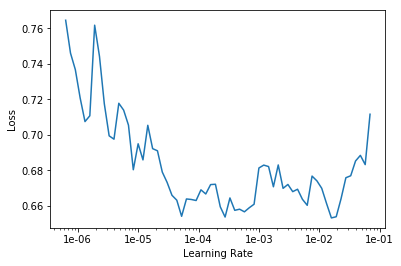

In [6]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [7]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.753888,0.701557,0.725753,01:01
1,0.765622,0.712718,0.715719,00:59
2,0.807483,0.570366,0.765886,01:00
3,0.767629,0.826294,0.672241,01:01
4,0.757164,0.584201,0.752508,01:01
5,0.717499,0.640720,0.742475,01:01
6,0.705340,0.730320,0.732441,01:01
7,0.681876,0.717696,0.722408,01:01
8,0.721857,0.804171,0.705686,01:01
9,0.684528,0.714399,0.725753,01:01


In [8]:
learn.save('no_tok_classifier')

In [9]:
learn.unfreeze()

In [10]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.677366,0.691327,0.739130,01:28
1,0.668106,0.608650,0.749164,01:29
2,0.693266,0.748062,0.692308,01:29
3,0.803239,0.674404,0.735786,01:29
4,0.795843,0.553469,0.775920,01:27
5,0.690545,0.571657,0.772575,01:29
6,0.695900,0.522005,0.789298,01:29
7,0.627800,0.523464,0.775920,01:28
8,0.640039,0.526279,0.789298,01:29
9,0.704805,0.554975,0.775920,01:28


In [11]:
learn.save('fine_tuned_classifier_no_tok')
learn.save_encoder('fine_tuned_enc_classifier_no_tok')

## What are the most frequently misclassified?

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_clas.valid_ds)==len(losses)==len(idxs)

True

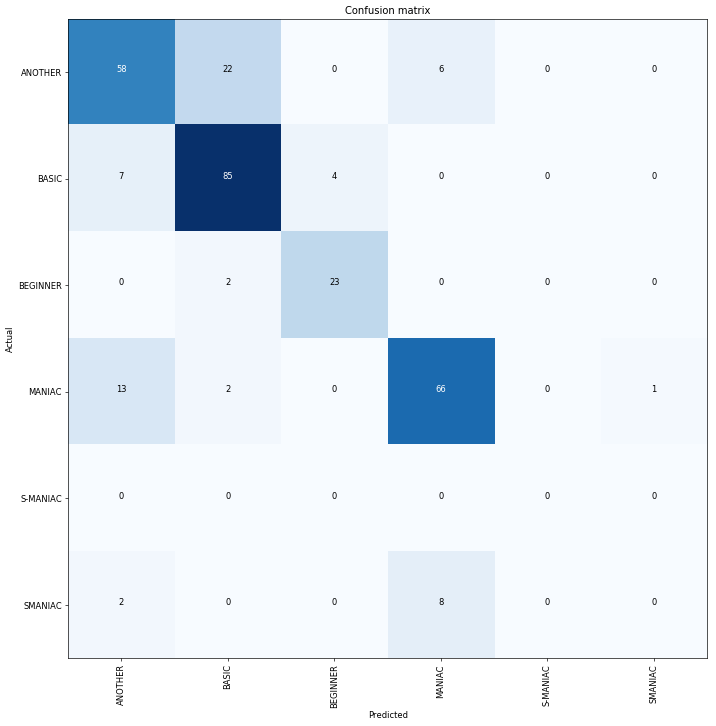

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [15]:
interp.most_confused(min_val=2)

[('ANOTHER', 'BASIC', 22),
 ('MANIAC', 'ANOTHER', 13),
 ('SMANIAC', 'MANIAC', 8),
 ('BASIC', 'ANOTHER', 7),
 ('ANOTHER', 'MANIAC', 6),
 ('BASIC', 'BEGINNER', 4),
 ('BEGINNER', 'BASIC', 2),
 ('MANIAC', 'BASIC', 2),
 ('SMANIAC', 'ANOTHER', 2)]